In [1]:
import pandas as pd
import os

os.chdir('..')
from utils.metrics import *
from utils.matching import *

In [2]:
import pickle

df_target = pd.read_pickle("data/authors_with_prospective_canonical_names.pkl", compression="zip")

In [3]:
df_source = pd.read_pickle("data/source/dnb.pkl", compression="zip")

In [4]:
df_source.head()

,name,link,page_number,text,dates,birth_year,death_year,floruit_years,last,first,middle
0,"Abbadie, Jacques",https://en.wikisource.org/wiki/Dictionary_of_N...,1,"ABBADIE , JACQUES (or JAMES), D.D.(1654?–1727...",NaN,NaN,NaN,NaN,Abbadie,Jacques,NaN
1,"Abbot, Charles (d.1817)",https://en.wikisource.org/wiki/Dictionary_of_N...,3,"ABBOT , CHARLES ( d. 1817) botanist, sometime...",d.1817,NaN,1817.0,NaN,Abbot,Charles,NaN
2,"Abbot, Charles (1757-1829)",https://en.wikisource.org/wiki/Dictionary_of_N...,3,"ABBOT , CHARLES, first Baron Colchester (1757...",1757-1829,1757.0,1829.0,1757-1829,Abbot,Charles,NaN
3,"Abbot, George (1562-1633)",https://en.wikisource.org/wiki/Dictionary_of_N...,5,"ABBOT , GEORGE (1562–1633), archbishop of Can...",1562-1633,1562.0,1633.0,1562-1633,Abbot,George,NaN
4,"Abbot, George (1603-1648)",https://en.wikisource.org/wiki/Dictionary_of_N...,20,"ABBOT , GEORGE (1603–1648), religious writer,...",1603-1648,1603.0,1648.0,1603-1648,Abbot,George,NaN


In [5]:
# The DNB does not include biographies of people who died after 1885, so we can filter out all authors who died after 1885
# Just because someone published before 1885 does not mean that they did not die much later and would not be in the DNB
# So, we'll just allow for a "Could not be resolved" category
df_target = df_target[df_target['year'] <= 1885]
df_target = df_target.reset_index(drop=True)

In [6]:
df_target

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,last,formatted_name,prospective
0,Lieut. J. H. Hennessey.,XIV. On the atmospheric lines of the Solar spe...,1870,Lieut. J. H. Hennessey.,['J. H. Hennessey.'],J. H. Hennessey,['lieut'],NaN,NaN,NaN,J. H. Hennessey,J. H. Hennessey,"[(Johnstone, James (1719-1800?), 0.31929824561..."
1,President.,XIV. On the atmospheric lines of the Solar spe...,1870,President.,[''],NaN,['president'],NaN,NaN,NaN,NaN,NaN,"[(nan, 0), (nan, 0), (nan, 0), (nan, 0), (nan,..."
2,"Earl of Rosse, F. R. S.",XV. On the radiation of heat from the moon.\#x...,1870,Earl of Rosse,"['Earl', 'of', 'Rosse']",Earl of Rosse,NaN,NaN,NaN,NaN,Earl of Rosse,Earl of Rosse,"[(Earle, William (1833-1885), 0.34412955465587..."
3,"W. H. L. Russell, F. R. S.",XVI. On linear differential equations. \#x2014...,1870,W. H. L. Russell,"['W.', 'H.', 'L.', 'Russell']",W. H. L. Russell,NaN,NaN,W.,H. L.,Russell,"Russell, W. H. L.","[(Russell, William (1741-1793), 0.667669172932..."
4,A. Le Sueur.,XVII. Observations with the great melbourne te...,1870,A. Le Sueur.,"['A.', 'Le', 'Sueur.']",A. Le Sueur,NaN,NaN,A.,Le,Sueur,"Sueur, A. Le","[(Stewart, Andrew (fl.1548-1593), 0.4862155388..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13644,W. E. Parry,Observations to determine the amount of Atmosp...,1826,W. E. Parry,"['W.', 'E.', 'Parry']",W. E. Parry,NaN,NaN,W.,E.,Parry,"Parry, W. E.","[(Parry, William (1687-1756?), 0.6676691729323..."
13645,Henry Foster,Observations to determine the amount of Atmosp...,1826,Henry Foster,"['Henry', 'Foster']",Henry Foster,NaN,NaN,Henry,NaN,Foster,"Foster, Henry","[(Ferrers, Henry (1549-1633), 0.68671679197995..."
13646,J. C. Ross,Observations to determine the amount of Atmosp...,1826,J. C. Ross,"['J.', 'C.', 'Ross']",J. C. Ross,NaN,NaN,J.,C.,Ross,"Ross, J. C.","[(Ross, John (1763-1837), 0.6842105263157896),..."
13647,William Thomson,The Bakerian Lecture.\#x2014;On the Electro-dy...,1856,William Thomson,"['William', 'Thomson']",William Thomson,NaN,NaN,William,NaN,Thomson,"Thomson, William","[(Thomson, William (1746-1817), 0.842105263157..."


In [7]:
weights = {
    "first_lev": 0.2,
    "first_jac": 0.2,
    "first_init": 0.2,
    "middle_lev": 0.1,
    "middle_jac": 0.1,
    "middle_init": 0.1,
    "last_lev": 0.4,
    "last_jac": 0.2,
    "last_init": 0.1,
    "year": 0.3
}

matches = match(df_target.iloc[10000], df_source, weights=weights)

In [8]:
matches

[('Rankine, William John Macquorn', 0.8421052631578947),
 ('Romaine, William (1714-1795)', 0.7124060150375939),
 ('Erskine, William (1769-1822)', 0.6691729323308271),
 ('Erskine, William (1769-1813)', 0.6691729323308271),
 ('Rae, William (1769-1842)', 0.6691729323308271),
 ('Rae, William (1786-1873)', 0.6691729323308271),
 ('Gardiner, William (1748-1806)', 0.6447368421052632),
 ('Gardiner, William (1770-1853)', 0.6447368421052632),
 ('Hawkins, William (1722-1801)', 0.6407685881370092),
 ('Hawkins, William (1673-1746)', 0.6407685881370092)]

In [34]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [10]:
# add prospective names to the whole target dataframe
df_target['prospective'] = df_target.parallel_apply(lambda x: match(x, df_source, weights=weights), axis=1)

In [71]:
# define a function to return names above a certain score threshold
def get_matches(row, threshold=0.7):
    matches = row['prospective']

    # get matches above threshold
    thresholded_matches = [match for match in matches if match[1] > threshold]

    return thresholded_matches

# define a function to return the best match if available from the thresholded matches
def get_best_match(row, threshold=0.7):
    # convert threshold to a string like "0.7" -> "70" or "0.725" -> "725"
    if threshold == 0.725:
        threshold_str = "725"
    else:
        threshold_str = str(int(threshold * 100))

    # build the column name
    column_name = f"matches_above_threshold_{threshold_str}"
    # get the matches
    matches = row[column_name]
    # if there are no matches, return None
    if len(matches) == 0:
        return None
    else:
        # return the best match without score
        return matches[0][0]
    
# define a function to print the average number of matches in a match column
def get_average_number_of_matches(col_name):
    return df_target.apply(lambda x: len(x[col_name]), axis=1).mean()

In [69]:
df_target

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,...,matches_above_threshold_80,matches_above_threshold_65,matches_above_threshold_75,best_match_60,best_match_65,best_match_70,best_match_75,best_match_80,matches_above_threshold_725,best_match_725
0,Lieut. J. H. Hennessey.,XIV. On the atmospheric lines of the Solar spe...,1870,Lieut. J. H. Hennessey.,['J. H. Hennessey.'],J. H. Hennessey,['lieut'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
1,President.,XIV. On the atmospheric lines of the Solar spe...,1870,President.,[''],NaN,['president'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
2,"Earl of Rosse, F. R. S.",XV. On the radiation of heat from the moon.\#x...,1870,Earl of Rosse,"['Earl', 'of', 'Rosse']",Earl of Rosse,NaN,NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
3,"W. H. L. Russell, F. R. S.",XVI. On linear differential equations. \#x2014...,1870,W. H. L. Russell,"['W.', 'H.', 'L.', 'Russell']",W. H. L. Russell,NaN,NaN,W.,H. L.,...,[],"[(Russell, William (1741-1793), 0.667669172932...",[],"Russell, William (1741-1793)","Russell, William (1741-1793)",None,None,None,[],None
4,A. Le Sueur.,XVII. Observations with the great melbourne te...,1870,A. Le Sueur.,"['A.', 'Le', 'Sueur.']",A. Le Sueur,NaN,NaN,A.,Le,...,[],[],[],None,None,None,None,None,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13644,W. E. Parry,Observations to determine the amount of Atmosp...,1826,W. E. Parry,"['W.', 'E.', 'Parry']",W. E. Parry,NaN,NaN,W.,E.,...,[],"[(Parry, William (1687-1756?), 0.6676691729323...",[],"Parry, William (1687-1756?)","Parry, William (1687-1756?)",None,None,None,[],None
13645,Henry Foster,Observations to determine the amount of Atmosp...,1826,Henry Foster,"['Henry', 'Foster']",Henry Foster,NaN,NaN,Henry,NaN,...,[],"[(Ferrers, Henry (1549-1633), 0.68671679197995...",[],"Ferrers, Henry (1549-1633)","Ferrers, Henry (1549-1633)",None,None,None,[],None
13646,J. C. Ross,Observations to determine the amount of Atmosp...,1826,J. C. Ross,"['J.', 'C.', 'Ross']",J. C. Ross,NaN,NaN,J.,C.,...,[],"[(Ross, John (1763-1837), 0.6842105263157896),...",[],"Ross, John (1763-1837)","Ross, John (1763-1837)",None,None,None,[],None
13647,William Thomson,The Bakerian Lecture.\#x2014;On the Electro-dy...,1856,William Thomson,"['William', 'Thomson']",William Thomson,NaN,NaN,William,NaN,...,"[(Thomson, William (1746-1817), 0.842105263157...","[(Thomson, William (1746-1817), 0.842105263157...","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)"


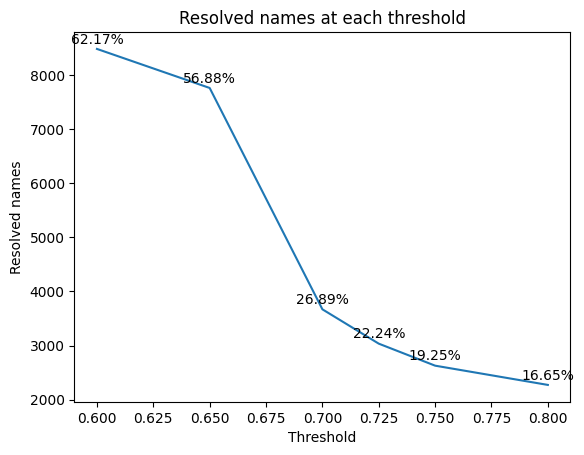

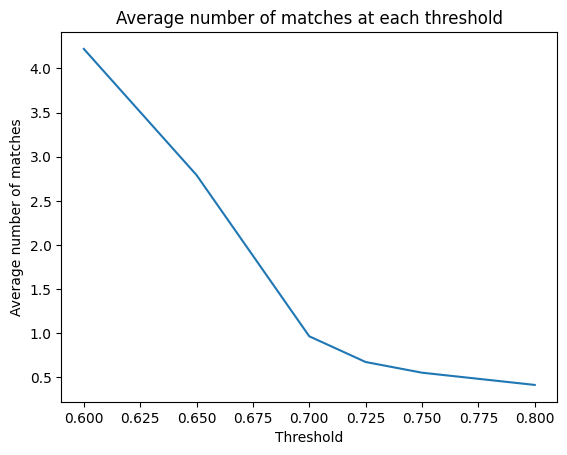

In [72]:
# apply the functions to the dataframe
# get matches above threshold
df_target['matches_above_threshold_60'] = df_target.apply(lambda x: get_matches(x, threshold=0.6), axis=1)
df_target['matches_above_threshold_65'] = df_target.apply(lambda x: get_matches(x, threshold=0.65), axis=1)
df_target['matches_above_threshold_70'] = df_target.apply(lambda x: get_matches(x, threshold=0.7), axis=1)
df_target['matches_above_threshold_725'] = df_target.apply(lambda x: get_matches(x, threshold=0.725), axis=1)
df_target['matches_above_threshold_75'] = df_target.apply(lambda x: get_matches(x, threshold=0.75), axis=1)
df_target['matches_above_threshold_80'] = df_target.apply(lambda x: get_matches(x, threshold=0.8), axis=1)

# get best matches at each threshold
df_target['best_match_60'] = df_target.apply(lambda x: get_best_match(x, threshold=0.6), axis=1)
# get the number of resolved names out of the total, with a percentage, e.g., (19.25%)
df_target['best_match_65'] = df_target.apply(lambda x: get_best_match(x, threshold=0.65), axis=1)
df_target['best_match_70'] = df_target.apply(lambda x: get_best_match(x, threshold=0.7), axis=1)
df_target['best_match_725'] = df_target.apply(lambda x: get_best_match(x, threshold=0.725), axis=1)
df_target['best_match_75'] = df_target.apply(lambda x: get_best_match(x, threshold=0.75), axis=1)
df_target['best_match_80'] = df_target.apply(lambda x: get_best_match(x, threshold=0.8), axis=1)

# save the dataframe
df_target.to_pickle("data/authors_with_prospective_canonical_names_and_matches.pkl", compression="zip")

# display the number of resolved names at each threshold
import matplotlib.pyplot as plt

thresholds = [0.6, 0.65, 0.7, 0.725, 0.75, 0.8]
threshold_names = ["60", "65", "70", "725", "75", "80"]

total = len(df_target)
resolved = [len(df_target[df_target[f"best_match_{name}"].notnull()]) for name in threshold_names]
percentages = [f"{round((r / total) * 100, 2)}%" for r in resolved]
plt.plot(thresholds, resolved)
# add percentages as text on top of the bars
for i, txt in enumerate(percentages):
    plt.text(thresholds[i], resolved[i] + 100, txt, ha='center')
plt.xlabel("Threshold")
plt.ylabel("Resolved names")
plt.title("Resolved names at each threshold")
plt.show()

# display the average number of matches at each threshold
averages = [get_average_number_of_matches(f"matches_above_threshold_{name}") for name in threshold_names]
plt.plot(thresholds, averages)
plt.xlabel("Threshold")
plt.ylabel("Average number of matches")
plt.title("Average number of matches at each threshold")
plt.show()

In [75]:
display(df_target.sample(20))

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,...,matches_above_threshold_80,matches_above_threshold_65,matches_above_threshold_75,best_match_60,best_match_65,best_match_70,best_match_75,best_match_80,matches_above_threshold_725,best_match_725
5691,Richard Davies,"Tables of Specific Gravities, Extracted from V...",1748,Richard Davies,"['Richard', 'Davies']",Richard Davies,NaN,NaN,Richard,NaN,...,"[(Davies, Richard (1635-1708), 0.8421052631578...","[(Davies, Richard (1635-1708), 0.8421052631578...","[(Davies, Richard (1635-1708), 0.8421052631578...","Davies, Richard (1635-1708)","Davies, Richard (1635-1708)","Davies, Richard (1635-1708)","Davies, Richard (1635-1708)","Davies, Richard (1635-1708)","[(Davies, Richard (1635-1708), 0.8421052631578...","Davies, Richard (1635-1708)"
2315,"Arthur Schuster, Ph. D., F. R. S.",The Bakerian Lecture. Experiments on the disch...,1884,Arthur Schuster,"['Arthur', 'Schuster']",Arthur Schuster,NaN,NaN,Arthur,NaN,...,[],"[(Chichester, Arthur (1606-1675), 0.6789473684...",[],"Chichester, Arthur (1606-1675)","Chichester, Arthur (1606-1675)",None,None,None,[],None
4944,Edmond Halley,Some Considerations about the Cause of the Uni...,1724,Edmond Halley,"['Edmond', 'Halley']",Edmond Halley,NaN,NaN,Edmond,NaN,...,[],"[(Harley, Edward (1689-1741), 0.65789473684210...",[],"Harley, Edward (1689-1741)","Harley, Edward (1689-1741)",None,None,None,[],None
555,"Dr. Sanderson, F. R. S.",X. On the diuretic action of \lt;italic\gt;Dig...,1873,Dr. Sanderson,['Sanderson'],Sanderson,['dr'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
7536,S. Horsley,An Abridged State of the Weather at London in ...,1775,S. Horsley,"['S.', 'Horsley']",S. Horsley,NaN,NaN,S.,NaN,...,[],[],[],None,None,None,None,None,[],None
11563,Gideon Algernon Mantell,Memoir on a Portion of the Lower Jaw of an Igu...,1837,Gideon Algernon Mantell,"['Gideon', 'Algernon', 'Mantell']",Gideon Algernon Mantell,NaN,NaN,Gideon,Algernon,...,"[(Mantell, Gideon Algernon, 0.8421052631578947)]","[(Mantell, Gideon Algernon, 0.8421052631578947)]","[(Mantell, Gideon Algernon, 0.8421052631578947)]","Mantell, Gideon Algernon","Mantell, Gideon Algernon","Mantell, Gideon Algernon","Mantell, Gideon Algernon","Mantell, Gideon Algernon","[(Mantell, Gideon Algernon, 0.8421052631578947)]","Mantell, Gideon Algernon"
7899,Joseph Banks,A Description of a New Construction of Eye-Gla...,1783,Joseph Banks,"['Joseph', 'Banks']",Joseph Banks,NaN,NaN,Joseph,NaN,...,[],"[(Banks, John (1709-1751), 0.7117794486215538)...",[],"Banks, John (1709-1751)","Banks, John (1709-1751)","Banks, John (1709-1751)",None,None,[],None
11501,Major Sabine,"On Magnetical Observations in Germany, Norway,...",1837,Major Sabine,['Sabine'],Sabine,['major'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
12592,William John Macquorn Rankine,On the General Integrals of the Equations of t...,1854,William John Macquorn Rankine,"['William', 'John', 'Macquorn', 'Rankine']",William John Macquorn Rankine,NaN,NaN,William,John Macquorn,...,"[(Rankine, William John Macquorn, 0.8421052631...","[(Rankine, William John Macquorn, 0.8421052631...","[(Rankine, William John Macquorn, 0.8421052631...","Rankine, William John Macquorn","Rankine, William John Macquorn","Rankine, William John Macquorn","Rankine, William John Macquorn","Rankine, William John Macquorn","[(Rankine, William John Macquorn, 0.8421052631...","Rankine, William John Macquorn"
4909,Hans Sloane,An Account of Elephants Teeth and Bones Found ...,1727,Hans Sloane,"['Hans', 'Sloane']",Hans Sloane,NaN,NaN,Hans,NaN,...,[],"[(Sloane, Hans, 0.6842105263157895)]",[],"Sloane, Hans","Sloane, Hans",None,None,None,[],None


In [11]:
# save the dataframe
df_target.to_pickle("data/authors_with_dnb_matches.pkl", compression="zip")

In [19]:
df_target = pd.read_pickle("data/authors_with_prospective_canonical_names_and_matches.pkl", compression="zip")

In [20]:
df_target

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,...,matches_above_threshold_80,matches_above_threshold_65,matches_above_threshold_75,best_match_60,best_match_65,best_match_70,best_match_75,best_match_80,matches_above_threshold_725,best_match_725
0,Lieut. J. H. Hennessey.,XIV. On the atmospheric lines of the Solar spe...,1870,Lieut. J. H. Hennessey.,['J. H. Hennessey.'],J. H. Hennessey,['lieut'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
1,President.,XIV. On the atmospheric lines of the Solar spe...,1870,President.,[''],NaN,['president'],NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
2,"Earl of Rosse, F. R. S.",XV. On the radiation of heat from the moon.\#x...,1870,Earl of Rosse,"['Earl', 'of', 'Rosse']",Earl of Rosse,NaN,NaN,NaN,NaN,...,[],[],[],None,None,None,None,None,[],None
3,"W. H. L. Russell, F. R. S.",XVI. On linear differential equations. \#x2014...,1870,W. H. L. Russell,"['W.', 'H.', 'L.', 'Russell']",W. H. L. Russell,NaN,NaN,W.,H. L.,...,[],"[(Russell, William (1741-1793), 0.667669172932...",[],"Russell, William (1741-1793)","Russell, William (1741-1793)",None,None,None,[],None
4,A. Le Sueur.,XVII. Observations with the great melbourne te...,1870,A. Le Sueur.,"['A.', 'Le', 'Sueur.']",A. Le Sueur,NaN,NaN,A.,Le,...,[],[],[],None,None,None,None,None,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13644,W. E. Parry,Observations to determine the amount of Atmosp...,1826,W. E. Parry,"['W.', 'E.', 'Parry']",W. E. Parry,NaN,NaN,W.,E.,...,[],"[(Parry, William (1687-1756?), 0.6676691729323...",[],"Parry, William (1687-1756?)","Parry, William (1687-1756?)",None,None,None,[],None
13645,Henry Foster,Observations to determine the amount of Atmosp...,1826,Henry Foster,"['Henry', 'Foster']",Henry Foster,NaN,NaN,Henry,NaN,...,[],"[(Ferrers, Henry (1549-1633), 0.68671679197995...",[],"Ferrers, Henry (1549-1633)","Ferrers, Henry (1549-1633)",None,None,None,[],None
13646,J. C. Ross,Observations to determine the amount of Atmosp...,1826,J. C. Ross,"['J.', 'C.', 'Ross']",J. C. Ross,NaN,NaN,J.,C.,...,[],"[(Ross, John (1763-1837), 0.6842105263157896),...",[],"Ross, John (1763-1837)","Ross, John (1763-1837)",None,None,None,[],None
13647,William Thomson,The Bakerian Lecture.\#x2014;On the Electro-dy...,1856,William Thomson,"['William', 'Thomson']",William Thomson,NaN,NaN,William,NaN,...,"[(Thomson, William (1746-1817), 0.842105263157...","[(Thomson, William (1746-1817), 0.842105263157...","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)"


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

/Users/jneumann/Repos/historical_entity_resolution/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# log to txt file
logger.addHandler(logging.FileHandler('logs/log.txt', 'a'))

In [13]:
df_source

,name,link,page_number,text,dates,birth_year,death_year,floruit_years,last,first,middle
0,"Abbadie, Jacques",https://en.wikisource.org/wiki/Dictionary_of_N...,1,"ABBADIE , JACQUES (or JAMES), D.D.(1654?–1727...",NaN,NaN,NaN,NaN,Abbadie,Jacques,NaN
1,"Abbot, Charles (d.1817)",https://en.wikisource.org/wiki/Dictionary_of_N...,3,"ABBOT , CHARLES ( d. 1817) botanist, sometime...",d.1817,NaN,1817.0,NaN,Abbot,Charles,NaN
2,"Abbot, Charles (1757-1829)",https://en.wikisource.org/wiki/Dictionary_of_N...,3,"ABBOT , CHARLES, first Baron Colchester (1757...",1757-1829,1757.0,1829.0,1757-1829,Abbot,Charles,NaN
3,"Abbot, George (1562-1633)",https://en.wikisource.org/wiki/Dictionary_of_N...,5,"ABBOT , GEORGE (1562–1633), archbishop of Can...",1562-1633,1562.0,1633.0,1562-1633,Abbot,George,NaN
4,"Abbot, George (1603-1648)",https://en.wikisource.org/wiki/Dictionary_of_N...,20,"ABBOT , GEORGE (1603–1648), religious writer,...",1603-1648,1603.0,1648.0,1603-1648,Abbot,George,NaN
...,...,...,...,...,...,...,...,...,...,...,...
28032,"Zuccaro, Federigo",https://en.wikisource.org/wiki/Dictionary_of_N...,423,"ZUCCARO , ZUCHARO , or ZUCCHERO , FEDERIGO (1...",NaN,NaN,NaN,NaN,Zuccaro,Federigo,NaN
28033,"Zucchi, Antonio Pietro",https://en.wikisource.org/wiki/Dictionary_of_N...,424,"ZUCCHI , ANTONIO PIETRO (1726–1795), painter,...",NaN,NaN,NaN,NaN,Zucchi,Antonio,Pietro
28034,"Zukertort, John Hermann",https://en.wikisource.org/wiki/Dictionary_of_N...,424,"ZUKERTORT , JOHN HERMANN (1842–1888), chess m...",NaN,NaN,NaN,NaN,Zukertort,John,Hermann
28035,"Zuylestein, William Henry (1645-1709)",https://en.wikisource.org/wiki/Dictionary_of_N...,426,"ZUYLESTEIN or ZULESTEIN , WILLIAM HENRY, firs...",1645-1709,1645.0,1709.0,1645-1709,Zuylestein,William,Henry


In [12]:
df_source[df_source["name"] == "Zuylestein, William Henry (1717-1781)"].iloc[0]["text"]

" ZUYLESTEIN or ZULESTEIN , WILLIAM HENRY [ Nassau de ], fourth Earl of Rochford (1717–1781), eldest son of Frederick Nassau de Zuylestein, third earl, by Bessy Savage, was born at St. Osyth Priory, Essex, on 17 Sept. 1717. His mother, who was the illegitimate daughter and heiress of Richard Savage, fourth earl Rivers [q. v.], by Elizabeth Colleton or Culleton, died on 23 June 1746, being then the widow of the Rev. Philip Carter ( Gent. Mag . 1746, pp. 328; Noble , Continuation of Granger , iii. 442). After education at Westminster school he was appointed a lord of the bedchamber in 1738 with a salary of 1,000 l . a year. In 1741 he inherited property from his uncle, Henry de Zuylestein, who died, unmarried, at Easton in the April of this year. Inheriting also strong whig views, he moved in the most influential society in London, and was in 1749 elected a member of White's. In 1748 he was nominated vice-admiral of Essex, and in the following year was sent as envoy extraordinary and ple

In [77]:
from nltk.tokenize import sent_tokenize

# define a row function to format a prompt with author data
def format_prompt(row, df_source, threshold=0.6, general_notes="Nothing to add."):

    if threshold == 0.725:
        threshold_str = "725"
    else:
        threshold_str = str(int(threshold * 100))

    try:
        author = row["author"]
    except Exception as e:
        logger.info("Error retrieving author: ", e)
        return None
    if pd.isna(author) or author == "" or author == "nan" or author == "None" or author == "NaN" or author == "none":
        return None
    try:
        prospective_names = row[f"matches_above_threshold_{threshold_str}"]
    except Exception as e:
        logger.info("Error retrieving prospective names: ", e)
        return None
    if len(prospective_names) == 0:
        return None
    try:
        title = row["title"]
    except Exception as e:
        logger.info("Error retrieving title: ", e)
        title = "No title available."
    if pd.isna(title) or title == "" or title == "nan" or title == "None" or title == "NaN" or title == "none":
        title = "No title available."
    try:
        year = row["year"]
    except Exception as e:
        logger.info("Error retrieving year: ", e)
        year = "No year available."
    if pd.isna(year) or year == "" or year == "nan" or year == "None" or year == "NaN" or year == "none":
        year = "No year available."
    try:
        names = [name for name, _ in prospective_names if not pd.isna(name)]
    except Exception as e:
        logger.info("Error retrieving names: ", e)
        names = []

    short_bios = []

    if len(names) == 0:
        return None
    
    for name in names:
        try:
            bio = df_source[df_source["name"] == name].iloc[0]["text"]
            try:
                # allow a maximum of 256 tokens
                short_bio = tokenizer.tokenize(bio)[:256]
                short_bio = tokenizer.convert_tokens_to_string(short_bio)
                try:
                    # use nltk to split sentences
                    sentencized = sent_tokenize(short_bio)
                    # filter for complete sentences
                    complete_sentences = []
                    for sent in sentencized:
                        if sent[-1] in [".", "!", "?"]:
                            complete_sentences.append(sent)
                    short_bio = " ".join(complete_sentences)
                except Exception as e:
                    logger.info("Error sentencizing bio: ", e)
                    try:
                        short_bio = bio[:256]
                    except Exception as e:
                        logger.info("Error truncating bio: ", e)
                        short_bio = "No bio available."
            except Exception as e:
                logger.info("Error tokenizing bio: ", e)
                try:
                    short_bio = bio[:256]
                except Exception as e:
                    logger.info("Error truncating bio: ", e)
                    short_bio = "No bio available."
        except Exception as e:
            logger.info("Error retrieving bio: ", e)
            short_bio = "No bio available."
        short_bios.append(short_bio)

    prompt = """INSTRUCTIONS:
Given information about the author and publication, please select the name from the list of prospective canonical names that makes the most sense. This is not a task where there has to be an answer. If none of the names make sense, or you are unsure, please select 'None'. And, remember, the selected name should at least resemble the original name.

CONTEXT:
General notes: {general_notes}
Author (target of entity resolution): {author}
Title of a publication of theirs: {title}
Publication year: {year}

CHOICE OF POTENTIAL NAMES WITH BIOS:
Name: None
Bio: None

""".format(author=author, title=title, year=year, general_notes=general_notes)

    for i in range(0, len(names)):
        prompt += "Name: " + names[i] + "\nBio: " + short_bios[i] + "\n\n"

    prompt += "What is the most likely name from the list provided? Please respond only with the name in the format it was found in the list, or None:\n".format(author=author)
    return prompt



In [78]:
notes = """None"""

prompt = format_prompt(df_target.iloc[10000], df_source, threshold=0.6, general_notes=notes)

print(prompt)


INSTRUCTIONS:
Given information about the author and publication, please select the name from the list of prospective canonical names that makes the most sense. This is not a task where there has to be an answer. If none of the names make sense, or you are unsure, please select 'None'. And, remember, the selected name should at least resemble the original name.

CONTEXT:
General notes: None
Author (target of entity resolution): William John Macquorn Rankine
Title of a publication of theirs: On the Thermo-Dynamic Theory of Steam-Engines with Dry Saturated Steam, and Its Application to Practice
Publication year: 1859

CHOICE OF POTENTIAL NAMES WITH BIOS:
Name: None
Bio: None

Name: Rankine, William John Macquorn
Bio:  RANKINE , WILLIAM JOHN MACQUORN (1820–1872), civil engineer, son of David Rankine ( d . 1870), engineer, by Barbara, daughter of Archibald Grahame, banker, of Glasgow, was born in Edinburgh on 5 July 1820. He was educated at Ayr academy in 1828–9, and at the high school of 

In [40]:
from tqdm import tqdm

tqdm.pandas()

In [79]:
notes = "(1) We know this author published in the Philosophical Transactions of the Royal Society, so it is likely that they are a scientist or adjacent to science. (2) We also know that the author may not be English, or may have died after the cutoff of the data we have, or may simply not be covered, so there may very well be no match. (3) Make sure the publication year is between the birth and death, or floruit, years if they are available."

In [80]:
df_target["prompt"] = df_target.parallel_apply(lambda row: format_prompt(row=row, df_source=df_source, general_notes=notes, threshold=0.6), axis=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [81]:
df_target_60 = df_target[df_target["prompt"].str.len() > 25]
df_target_60 = df_target_60.reset_index(drop=True)

print(len(df_target_60))

8485


In [82]:
df_target_60

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,...,matches_above_threshold_65,matches_above_threshold_75,best_match_60,best_match_65,best_match_70,best_match_75,best_match_80,matches_above_threshold_725,best_match_725,prompt
0,"W. H. L. Russell, F. R. S.",XVI. On linear differential equations. \#x2014...,1870,W. H. L. Russell,"['W.', 'H.', 'L.', 'Russell']",W. H. L. Russell,NaN,NaN,W.,H. L.,...,"[(Russell, William (1741-1793), 0.667669172932...",[],"Russell, William (1741-1793)","Russell, William (1741-1793)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
1,"J. Broughton, B. Sc., F. C. S.",XVIII. Chemical and physiological experiments ...,1870,J. Broughton,"['J.', 'Broughton']",J. Broughton,NaN,NaN,J.,NaN,...,"[(Broughton, John (1705-1789), 0.6842105263157...",[],"Broughton, John (1705-1789)","Broughton, John (1705-1789)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
2,Dr. Edward Frankland.,XVIII. Chemical and physiological experiments ...,1870,Dr. Edward Frankland.,"['Edward', 'Frankland.']",Edward Frankland,['dr'],NaN,Edward,NaN,...,[],[],"Fitzgerald, Edward (1809-1883)",None,None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
3,"Charles Brooke, M. A.",XXI. Researches in animal electricity.,1870,Charles Brooke,"['Charles', 'Brooke']",Charles Brooke,NaN,NaN,Charles,NaN,...,"[(Brooke, Charles (1777-1852), 0.8421052631578...","[(Brooke, Charles (1777-1852), 0.8421052631578...","Brooke, Charles (1777-1852)","Brooke, Charles (1777-1852)","Brooke, Charles (1777-1852)","Brooke, Charles (1777-1852)","Brooke, Charles (1777-1852)","[(Brooke, Charles (1777-1852), 0.8421052631578...","Brooke, Charles (1777-1852)",INSTRUCTIONS:\nGiven information about the aut...
4,"Frederick Guthrie, B. A.",On approach caused by vibration.,1870,Frederick Guthrie,"['Frederick', 'Guthrie']",Frederick Guthrie,NaN,NaN,Frederick,NaN,...,"[(Guthrie, Frederick, 0.6842105263157895)]",[],"Guthrie, Frederick","Guthrie, Frederick",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8480,W. E. Parry,Observations to determine the amount of Atmosp...,1826,W. E. Parry,"['W.', 'E.', 'Parry']",W. E. Parry,NaN,NaN,W.,E.,...,"[(Parry, William (1687-1756?), 0.6676691729323...",[],"Parry, William (1687-1756?)","Parry, William (1687-1756?)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
8481,Henry Foster,Observations to determine the amount of Atmosp...,1826,Henry Foster,"['Henry', 'Foster']",Henry Foster,NaN,NaN,Henry,NaN,...,"[(Ferrers, Henry (1549-1633), 0.68671679197995...",[],"Ferrers, Henry (1549-1633)","Ferrers, Henry (1549-1633)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
8482,J. C. Ross,Observations to determine the amount of Atmosp...,1826,J. C. Ross,"['J.', 'C.', 'Ross']",J. C. Ross,NaN,NaN,J.,C.,...,"[(Ross, John (1763-1837), 0.6842105263157896),...",[],"Ross, John (1763-1837)","Ross, John (1763-1837)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...
8483,William Thomson,The Bakerian Lecture.\#x2014;On the Electro-dy...,1856,William Thomson,"['William', 'Thomson']",William Thomson,NaN,NaN,William,NaN,...,"[(Thomson, William (1746-1817), 0.842105263157...","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","Thomson, William (1746-1817)","[(Thomson, William (1746-1817), 0.842105263157...","Thomson, William (1746-1817)",INSTRUCTIONS:\nGiven information about the aut...


# Answer the Prompts with an LLM

In [83]:
print(df_target.iloc[8256]["prompt"])

INSTRUCTIONS:
Given information about the author and publication, please select the name from the list of prospective canonical names that makes the most sense. This is not a task where there has to be an answer. If none of the names make sense, or you are unsure, please select 'None'. And, remember, the selected name should at least resemble the original name.

CONTEXT:
General notes: (1) We know this author published in the Philosophical Transactions of the Royal Society, so it is likely that they are a scientist or adjacent to science. (2) We also know that the author may not be English, or may have died after the cutoff of the data we have, or may simply not be covered, so there may very well be no match. (3) Make sure the publication year is between the birth and death, or floruit, years if they are available.
Author (target of entity resolution): Joseph Banks
Title of a publication of theirs: Description of the Double Horned Rhinoceros of Sumatra. By Mr. William Bell, Surgeon in 

In [84]:
# Example: reuse your existing OpenAI setup
from openai import OpenAI

# Point to the local server
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

In [85]:
df_test = df_target_60.sample(20).reset_index(drop=True)

In [90]:
df_test

,author,title,year,full_name,corrected_name,corrected_name.1,titles,credentials,first,middle,...,matches_above_threshold_75,best_match_60,best_match_65,best_match_70,best_match_75,best_match_80,matches_above_threshold_725,best_match_725,prompt,resolved
0,Matthew Maty,Observations of the Eclipse of the Sun on the ...,1766,Matthew Maty,"['Matthew', 'Maty']",Matthew Maty,NaN,NaN,Matthew,NaN,...,[],"Maty, Matthew","Maty, Matthew",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Maty, Matthew"
1,Richard Dunthorne,A Letter from Mr. Rich. Dunthorne to the Rev. ...,1751,Richard Dunthorne,"['Richard', 'Dunthorne']",Richard Dunthorne,NaN,NaN,Richard,NaN,...,[],"Dunthorne, Richard","Dunthorne, Richard",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Dunthorne, Richard"
2,John Bond,A Letter to Sir Peter Thompson; Knt: F. R. S. ...,1753,John Bond,"['John', 'Bond']",John Bond,NaN,NaN,John,NaN,...,"[(Bond, John (1612-1676), 0.8421052631578947),...","Bond, John (1612-1676)","Bond, John (1612-1676)","Bond, John (1612-1676)","Bond, John (1612-1676)","Bond, John (1612-1676)","[(Bond, John (1612-1676), 0.8421052631578947),...","Bond, John (1612-1676)",INSTRUCTIONS:\nGiven information about the aut...,None
3,Thomas Henry Huxley,On the Anatomy and the Affinities of the Famil...,1849,Thomas Henry Huxley,"['Thomas', 'Henry', 'Huxley']",Thomas Henry Huxley,NaN,NaN,Thomas,Henry,...,[],"Hervey, Thomas (1698-1775)","Hervey, Thomas (1698-1775)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,None
4,Henry Barham,"A Letter of the Curious Mr. Henry Barham, R. S...",1717,Henry Barham,"['Henry', 'Barham']",Henry Barham,NaN,NaN,Henry,NaN,...,[],"Brougham, Henry (1665-1698)","Brougham, Henry (1665-1698)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Barham, Henry"
5,James B. Jordan,III. On the construction of a glycerine barome...,1879,James B. Jordan,"['James', 'B.', 'Jordan']",James B. Jordan,NaN,NaN,James,B.,...,[],"Gordon, James (1553-1641)","Gordon, James (1553-1641)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,None
6,George Fisher,An Account of Some Experiments Made in the Wes...,1830,George Fisher,"['George', 'Fisher']",George Fisher,NaN,NaN,George,NaN,...,[],"Fisher, George","Fisher, George",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Fisher, George"
7,Edward Waring,Some Properties of the Sum of the Divisors of ...,1788,Edward Waring,"['Edward', 'Waring']",Edward Waring,NaN,NaN,Edward,NaN,...,[],"Waring, Edward","Waring, Edward",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Waring, Edward"
8,F. J. H. Wollaston,Extract of a Letter from F. J. H. Wollaston (D...,1790,F. J. H. Wollaston,"['F.', 'J.', 'H.', 'Wollaston']",F. J. H. Wollaston,NaN,NaN,F.,J. H.,...,[],"Wollaston, Francis (1731-1815)","Wollaston, Francis (1731-1815)",None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,"Wollaston, Francis (1731-1815)"
9,"Dr. J. Dalton Hooker, C. B.","The annual meeting, June 1, 1876.",1876,Dr. J. Dalton Hooker,"['J.', 'Dalton', 'Hooker']",J. Dalton Hooker,['dr'],NaN,J.,Dalton,...,[],"Holker, John (1828-1882)",None,None,None,None,[],None,INSTRUCTIONS:\nGiven information about the aut...,None


In [93]:
import time

In [94]:
def generate_completion(row, client, model="gpt-4"):

    prompt = row["prompt"]
    if prompt is None:
        return None
    
    original_author = row["author"]
    if pd.isna(original_author) or original_author == "" or original_author == "nan" or original_author == "None" or original_author == "NaN" or original_author == "none":
        return None
    
    try:
        completion = client.chat.completions.create(
            model=model, # this field is currently unused
            messages=[
                {"role": "system", "content": "You follow instructions very well."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0001,
        )
    except Exception as e:
        # try again
        time.sleep(10)
        try:
            completion = client.chat.completions.create(
                model=model, # this field is currently unused
                messages=[
                    {"role": "system", "content": "You follow instructions very well."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0001,
            )
        except Exception as e:
            return None

    print("Original name: ", original_author)
    print("Resolved name: ", completion.choices[0].message.content)

    return completion.choices[0].message.content

In [95]:
df_target["resolved"] = df_target.parallel_apply(lambda row: generate_completion(row, client), axis=1)

Original name:  Hans Sloane
Resolved name:  Sloane, Hans
Original name:  Thomas Andrews
Resolved name:  Anderson, Thomas (1819-1874)
Original name:  Edward Frankland
Resolved name:  None
Original name:  Henry Baker
Resolved name:  Baker, Henry (1698-1774)
Original name:  James Bruce
Resolved name:  Bruce, James (1730-1794)
Original name:  Robert Clarke
Resolved name:  None
Original name:  Samuel Reynardson
Resolved name:  None
Original name:  Arthur Cayley
Resolved name:  Cayley, Arthur
Original name: Original name:   Henry E. RoscoeJohn Strange

Resolved name: Resolved name:   Roscoe, HenryStrange, John (1732-1799)

Original name:  John Waddell
Resolved name:  None
Original name:  Gowin Knight
Resolved name:  Knight, Gowin
Original name:  George Buist
Resolved name:  Buist, George
Original name:  Richard Price
Resolved name:  Price, Richard (1723-1791)
Original name:  Hans Sloane
Resolved name:  Sloane, Hans
Original name:  Robert Lee
Resolved name:  Lee, Robert (1793-1877)
Original n

In [104]:
# remove unresolved rows
df_resolved = df_target[df_target["resolved"].notnull()].reset_index(drop=True)
df_resolved = df_resolved[df_resolved["resolved"].str.lower() != "none"].reset_index(drop=True)
df_resolved = df_resolved.drop_duplicates(subset=["author"]).reset_index(drop=True)
df_resolved = df_resolved[['author', 'resolved']]

In [109]:
# remove Cayley, Arthur (1821-1895) because it is a duplicate
df_resolved = df_resolved[df_resolved["resolved"] != "Cayley, Arthur"].reset_index(drop=True)
df_resolved

,author,resolved
0,"Charles Brooke, M. A.","Brooke, Charles (1804-1879)"
1,"Frederick Guthrie, B. A.","Guthrie, Frederick"
2,Prof. W. J. Macquorn Rankine.,"Rankine, William John Macquorn"
3,"W. J. Macquorn Rankine, C. E., LL. D., F. R. S.","Rankine, William John Macquorn"
4,"Augustus Matthiessen, F. R. S.","Matthiessen, Augustus"
...,...,...
1434,William Hanry Flower,"Flower, William"
1435,Robert H. Scott,"Scott, Robert (1811-1887)"
1436,Arthur Leared,"Leared, Arthur"
1437,Richard A. Proctor,"Proctor, Richard Anthony"


In [110]:
len(df_resolved.resolved.unique())

1053

In [112]:
# get bios for resolved names
dnb = pd.read_pickle("data/source/dnb.pkl", compression="zip")

def get_bio(row, df):
    try:
        bio = df[df["name"].str.lower() == row["resolved"].lower()].iloc[0]["text"]
    except Exception as e:
        bio = None
    return bio

df_resolved["bio"] = df_resolved.progress_apply(lambda row: get_bio(row, dnb), axis=1)

100%|██████████| 1439/1439 [00:03<00:00, 394.29it/s]


In [113]:
df_resolved

,author,resolved,bio
0,"Charles Brooke, M. A.","Brooke, Charles (1804-1879)","BROOKE , CHARLES (1804–1879), surgeon and inv..."
1,"Frederick Guthrie, B. A.","Guthrie, Frederick","GUTHRIE , FREDERICK (1833–1886), scientific w..."
2,Prof. W. J. Macquorn Rankine.,"Rankine, William John Macquorn","RANKINE , WILLIAM JOHN MACQUORN (1820–1872), ..."
3,"W. J. Macquorn Rankine, C. E., LL. D., F. R. S.","Rankine, William John Macquorn","RANKINE , WILLIAM JOHN MACQUORN (1820–1872), ..."
4,"Augustus Matthiessen, F. R. S.","Matthiessen, Augustus","MATTHIESSEN , AUGUSTUS (1831–1870), chemist a..."
...,...,...,...
1434,William Hanry Flower,"Flower, William","FLOWER , WILLIAM (1498?–1588), Norroy king of..."
1435,Robert H. Scott,"Scott, Robert (1811-1887)","SCOTT , ROBERT (1811–1887), lexicographer and..."
1436,Arthur Leared,"Leared, Arthur","LEARED , ARTHUR, M.D. (1822–1879), traveller,..."
1437,Richard A. Proctor,"Proctor, Richard Anthony","PROCTOR , RICHARD ANTHONY (1837–1888), astron..."


In [114]:
# save the dataframe
df_resolved.to_pickle("data/authors_with_dnb_names_and_bios.pkl", compression="zip")

In [115]:
rsc = pd.read_csv("data/rsc_with_text_and_modified_text.csv")

In [118]:
# split author by | and store in new column, "authors" as a list of authors
rsc["authors"] = rsc["author"].str.split("|")

In [119]:
# make sure that the authors are lists
rsc["authors"] = rsc["authors"].apply(lambda x: x if type(x) == list else [x])

In [120]:
# explode the authors column
rsct = rsc.explode("authors")

In [123]:
# define a function to get retrieve resolved names and bios and apply them to the dataframe
def get_resolved_name_and_bio(row, df):
    try:
        resolved = df[df["author"].str.lower() == row["authors"].lower()].iloc[0]["resolved"]
    except Exception as e:
        resolved = None
    try:
        bio = df[df["author"].str.lower() == row["authors"].lower()].iloc[0]["bio"]
    except Exception as e:
        bio = None
    return resolved, bio

# apply the function to the dataframe
rsct[["resolved", "bio"]] = rsct.progress_apply(lambda row: get_resolved_name_and_bio(row, df_resolved), axis=1, result_type="expand")

100%|██████████| 23602/23602 [00:10<00:00, 2199.55it/s]


In [124]:
# count the number of rows with resolved names and bios
resolved = len(rsct[rsct["resolved"].notnull()])
total = len(rsct)
percentage = (resolved / total) * 100
print(f"Resolved: {resolved}, Total: {total}, Percentage: {percentage}%")

Resolved: 6282, Total: 23602, Percentage: 26.616388441657485%


In [125]:
rsct

,id,issn,title,fpage,lpage,year,volume,journal,author,type,...,isAbstractOf,primaryTopic,primaryTopicPercentage,secondaryTopic,secondaryTopicPercentage,text,modified_text,authors,resolved,bio
0,rspa_1905_0002,0950-1207,"The boring of the Simplon Tunnel, and the dist...",29,33,1905,76,Proceedings of the Royal Society of London. Se...,"Francis Fox, M. Inst. C. E. |C. V. Boys, F. R. S.",article,...,NaN,Geography,34.843817,Thermodynamics,26.224835,"The Boring of the Simplon Tunnel , etc. 29* Hu...","The Boring of the Simplon Tunnel , etc. 29* Hu...","Francis Fox, M. Inst. C. E.",None,None
0,rspa_1905_0002,0950-1207,"The boring of the Simplon Tunnel, and the dist...",29,33,1905,76,Proceedings of the Royal Society of London. Se...,"Francis Fox, M. Inst. C. E. |C. V. Boys, F. R. S.",article,...,NaN,Geography,34.843817,Thermodynamics,26.224835,"The Boring of the Simplon Tunnel , etc. 29* Hu...","The Boring of the Simplon Tunnel , etc. 29* Hu...","C. V. Boys, F. R. S.",None,None
1,rspa_1905_0003,0950-1207,On a method of finding the conductivity for heat.,34,48,1905,76,Proceedings of the Royal Society of London. Se...,"Professor C. Niven, F. R. S.",article,...,NaN,Electricity,22.229782,Formulae,19.054271,]\gt ; ; 34 Prof. C. Niven .\nOn Method of [ D...,]> ; 34 Prof. C. Niven . On Method of [ Dec. 5...,"Professor C. Niven, F. R. S.",None,None
2,rspa_1905_0004,0950-1207,Theory of the reflection of light near the pol...,49,65,1905,76,Proceedings of the Royal Society of London. Se...,"Richard C. Maclaurin, M. A., LL. D.|Professor ...",article,...,NaN,Tables,38.543461,Fluid Dynamics,28.361855,]\gt ; Tloeory of the Reflection of Laght the ...,]> ; Tloeory of the Reflection of Laght the Po...,"Richard C. Maclaurin, M. A., LL. D.",None,None
2,rspa_1905_0004,0950-1207,Theory of the reflection of light near the pol...,49,65,1905,76,Proceedings of the Royal Society of London. Se...,"Richard C. Maclaurin, M. A., LL. D.|Professor ...",article,...,NaN,Tables,38.543461,Fluid Dynamics,28.361855,]\gt ; Tloeory of the Reflection of Laght the ...,]> ; Tloeory of the Reflection of Laght the Po...,"Professor J. Larmor, Sec. R. S.",None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16739,41141785,02610523,Observations to determine the amount of Atmosp...,206,230,1826,116,Philosophical Transactions of the Royal Societ...,W. E. Parry|Henry Foster|J. C. Ross,fla,...,NaN,Astronomy,61.861393,Meteorology,19.819962,IX .\nObservations to determine the amount of ...,IX . Observations to determine the amount of A...,W. E. Parry,None,None
16739,41141785,02610523,Observations to determine the amount of Atmosp...,206,230,1826,116,Philosophical Transactions of the Royal Societ...,W. E. Parry|Henry Foster|J. C. Ross,fla,...,NaN,Astronomy,61.861393,Meteorology,19.819962,IX .\nObservations to determine the amount of ...,IX . Observations to determine the amount of A...,Henry Foster,"Foster, Henry","FOSTER , HENRY (1796–1831), navigator, born i..."
16739,41141785,02610523,Observations to determine the amount of Atmosp...,206,230,1826,116,Philosophical Transactions of the Royal Societ...,W. E. Parry|Henry Foster|J. C. Ross,fla,...,NaN,Astronomy,61.861393,Meteorology,19.819962,IX .\nObservations to determine the amount of ...,IX . Observations to determine the amount of A...,J. C. Ross,"Ross, John (1777-1856)","ROSS , Sir JOHN (1777–1856), rear-admiral and..."
16740,41206195,02610523,The Bakerian Lecture.\#x2014;On the Electro-dy...,649,751,1856,146,Philosophical Transactions of the Royal Societ...,William Thomson,fla,...,NaN,Electricity,49.679423,Measurement,26.395864,Some observations of Regnault 's having appear...,Some observations of Regnault 's having appear...,William Thomson,"Thomson, William (1819-1890)","THOMSON , WILLIAM (1819–1890), archbishop of ..."


In [126]:
# save the dataframe
rsct.to_pickle("data/rsc_with_text_modified_text_resolved_names_and_bios.pkl", compression="zip")

In [127]:
# save a version of the dataframe with rows containing resolved names and bios
rsct_resolved = rsct[rsct["resolved"].notnull()]

print("Difference: ", len(rsct_resolved) - len(rsct))

Difference:  -17320


In [129]:
rsct_resolved = rsct_resolved.reset_index(drop=True)

In [136]:
rsct_resolved

,id,issn,title,fpage,lpage,year,volume,journal,author,type,...,isAbstractOf,primaryTopic,primaryTopicPercentage,secondaryTopic,secondaryTopicPercentage,text,modified_text,authors,resolved,bio
0,rspa_1909_0086,0950-1207,Harmonic tidal constants for certain Chinese a...,127,130,1909,83,Proceedings of the Royal Society of London. Se...,"Thomas Wright|Sir George H. Darwin, K. C. B., ...",article,...,NaN,Meteorology,45.186419,Tables,18.209093,"Harmonic Tidal Constants , etc. In the table i...","Harmonic Tidal Constants , etc. In the table i...",Thomas Wright,"Wright, Thomas (fl.1740-1760)","WRIGHT , THOMAS ( fl . 1740–1760), author of ..."
1,rspa_1920_0042,0950-1207,Obituary notices of fellows deceased.,0,0,1920,97,Proceedings of the Royal Society of London. Se...,William Watson,article,...,NaN,Biography,69.344447,Meteorology,6.751422,OBITUARY NOTICES FELLOWS DECEASED .\nVOL. XCVI...,OBITUARY NOTICES FELLOWS DECEASED . VOL. XCVII...,William Watson,"Watson, William (1715-1787)","WATSON , Sir WILLIAM (1715–1787), physician, ..."
2,rspb_1914_0004,0950-1193,The alleged excretion of creatine in carbohydr...,205,220,1914,87,Proceedings of the Royal Society of London. Se...,"George Graham|E. P. Poulton|Dr. F. G. Hopkins,...",article,...,NaN,Biochemistry,76.408311,Chemistry 2,15.401245,205 The Alleged Excretion of Creatine in Carbo...,205 The Alleged Excretion of Creatine in Carbo...,George Graham,"Graham, George (1675-1751)","GRAHAM , GEORGE (1675–1751), mechanician, was..."
3,rspl_1870_0006,0370-1662,XVI. On linear differential equations. \#x2014...,14,17,1870,19,Proceedings of the Royal Society of London,"W. H. L. Russell, F. R. S.",abstract,...,NaN,Formulae,71.760816,Tables,26.947171,]\gt ; 14 Mr. W. H. L. Russell on Linear Diffe...,]> ; 14 Mr. W. H. L. Russell on Linear Differe...,"W. H. L. Russell, F. R. S.","Russell, William (1822-1892)","RUSSELL , Sir WILLIAM (1822–1892), lieutenant..."
4,rspl_1870_0011,0370-1662,XXI. Researches in animal electricity.,22,28,1870,19,Proceedings of the Royal Society of London,"C. B. Radcliffe, M. D.|Charles Brooke, M. A.",abstract,...,NaN,Electricity,48.020748,Nervous System,35.838707,"22 Dr , C. B. RadclifFe on Animal Electricity ...","22 Dr , C. B. RadclifFe on Animal Electricity ...","Charles Brooke, M. A.","Brooke, Charles (1804-1879)","BROOKE , CHARLES (1804–1879), surgeon and inv..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6277,41141783,02610523,A comparison of the diurnal changes of intensi...,177,187,1826,116,Philosophical Transactions of the Royal Societ...,Henry Foster,fla,...,NaN,Meteorology,43.051230,Astronomy,30.676141,VII .\nA comparison of the diurnal changes oj ...,VII . A comparison of the diurnal changes oj i...,Henry Foster,"Foster, Henry","FOSTER , HENRY (1796–1831), navigator, born i..."
6278,41141784,02610523,Account of the repetition of Mr. Christie&apos...,188,205,1826,116,Philosophical Transactions of the Royal Societ...,S. H. CHRISTIE|Henry Foster,fla,...,NaN,Measurement,32.441429,Meteorology,26.965145,VIII .\nAccount of the repetition of Mr. Chris...,VIII . Account of the repetition of Mr. Christ...,Henry Foster,"Foster, Henry","FOSTER , HENRY (1796–1831), navigator, born i..."
6279,41141785,02610523,Observations to determine the amount of Atmosp...,206,230,1826,116,Philosophical Transactions of the Royal Societ...,W. E. Parry|Henry Foster|J. C. Ross,fla,...,NaN,Astronomy,61.861393,Meteorology,19.819962,IX .\nObservations to determine the amount of ...,IX . Observations to determine the amount of A...,Henry Foster,"Foster, Henry","FOSTER , HENRY (1796–1831), navigator, born i..."
6280,41141785,02610523,Observations to determine the amount of Atmosp...,206,230,1826,116,Philosophical Transactions of the Royal Societ...,W. E. Parry|Henry Foster|J. C. Ross,fla,...,NaN,Astronomy,61.861393,Meteorology,19.819962,IX .\nObservations to determine the amount of ...,IX . Observations to determine the amount of A...,J. C. Ross,"Ross, John 

In [135]:
# print number of unique titles
print("Unique titles: ", len(rsct_resolved.title.unique()))

# print number of unique resolved names
print("Unique resolved names: ", len(rsct_resolved.resolved.unique()))

Unique titles:  5852
Unique resolved names:  1053


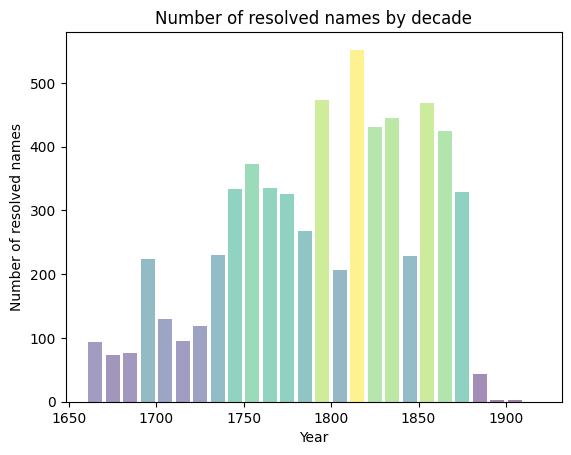

/var/folders/th/ztbjvht57g7497y111r50djm0000gn/T/ipykernel_23092/3496852966.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_documents = rsct_resolved.groupby(pd.cut(rsct_resolved["year"], np.arange(min_year, max_year + 1, 10))).title.nunique()


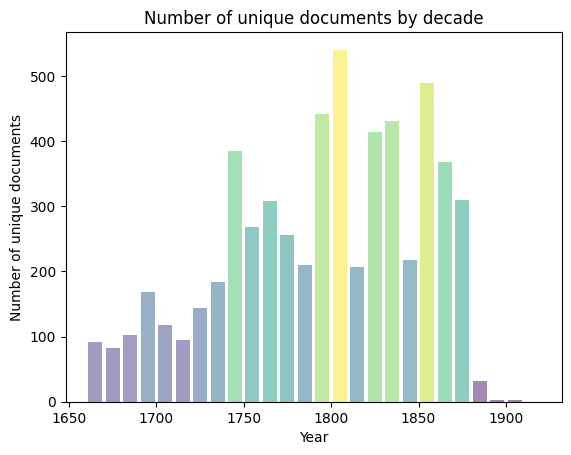

In [160]:
import numpy as np
# plot the number of resolved names by decade
# add a gradient to the bars based on the number of resolved names
import matplotlib.pyplot as plt

# convert the year column to a int
rsct_resolved["year"] = rsct_resolved["year"].astype(int)

# get the lowest and highest year
min_year = rsct_resolved["year"].min()
max_year = rsct_resolved["year"].max()

# create a list of decades
decades = list(range(min_year, max_year + 1, 10))

# create a list of decade counts
decade_counts = []

# iterate over the decades
for i in range(len(decades) - 1):
    # get the count of resolved names in the decade
    count = len(rsct_resolved[(rsct_resolved["year"] >= decades[i]) & (rsct_resolved["year"] < decades[i + 1])])
    # append the count to the list
    decade_counts.append(count)

# Ensure that decade_counts has the same length as decades
if len(decade_counts) < len(decades):
    decade_counts.append(0)

# convert decade_counts to a numpy array
decade_counts = np.array(decade_counts)

# thicken the bars
plt.bar(decades, decade_counts, width=8, color=plt.cm.viridis((decade_counts - np.min(decade_counts)) / (np.max(decade_counts) - np.min(decade_counts))), alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Number of resolved names")
plt.title("Number of resolved names by decade")
plt.show()

# plot the number of unique documents by decade
# add a gradient to the bars based on the number of unique documents

# get the number of unique documents by decade
unique_documents = rsct_resolved.groupby(pd.cut(rsct_resolved["year"], np.arange(min_year, max_year + 1, 10))).title.nunique()

# convert unique_documents to a numpy array
unique_documents = unique_documents.to_numpy()

if len(unique_documents) < len(decades):
    unique_documents = np.append(unique_documents, 0)

# plot
plt.bar(decades, unique_documents, width=8, color=plt.cm.viridis((unique_documents - np.min(unique_documents)) / (np.max(unique_documents) - np.min(unique_documents))), alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Number of unique documents")
plt.title("Number of unique documents by decade")
plt.show()


In [156]:
# save the dataframe
rsct_resolved.to_pickle("data/rsc_dnb.pkl", compression="zip")